In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\User\\Desktop\\shrina\\Affine\\Project\\clustering example\\data.csv", delimiter=',', encoding = "ISO-8859-1")

df.head().T
df.shape

(541909, 8)

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import missingno as msno
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [3]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
# Describe the non-numeric features
df.describe(exclude=['float64','int64']).T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [5]:
# Describe the  numeric fearture
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Total number of obseration is: 541909


<Axes: >

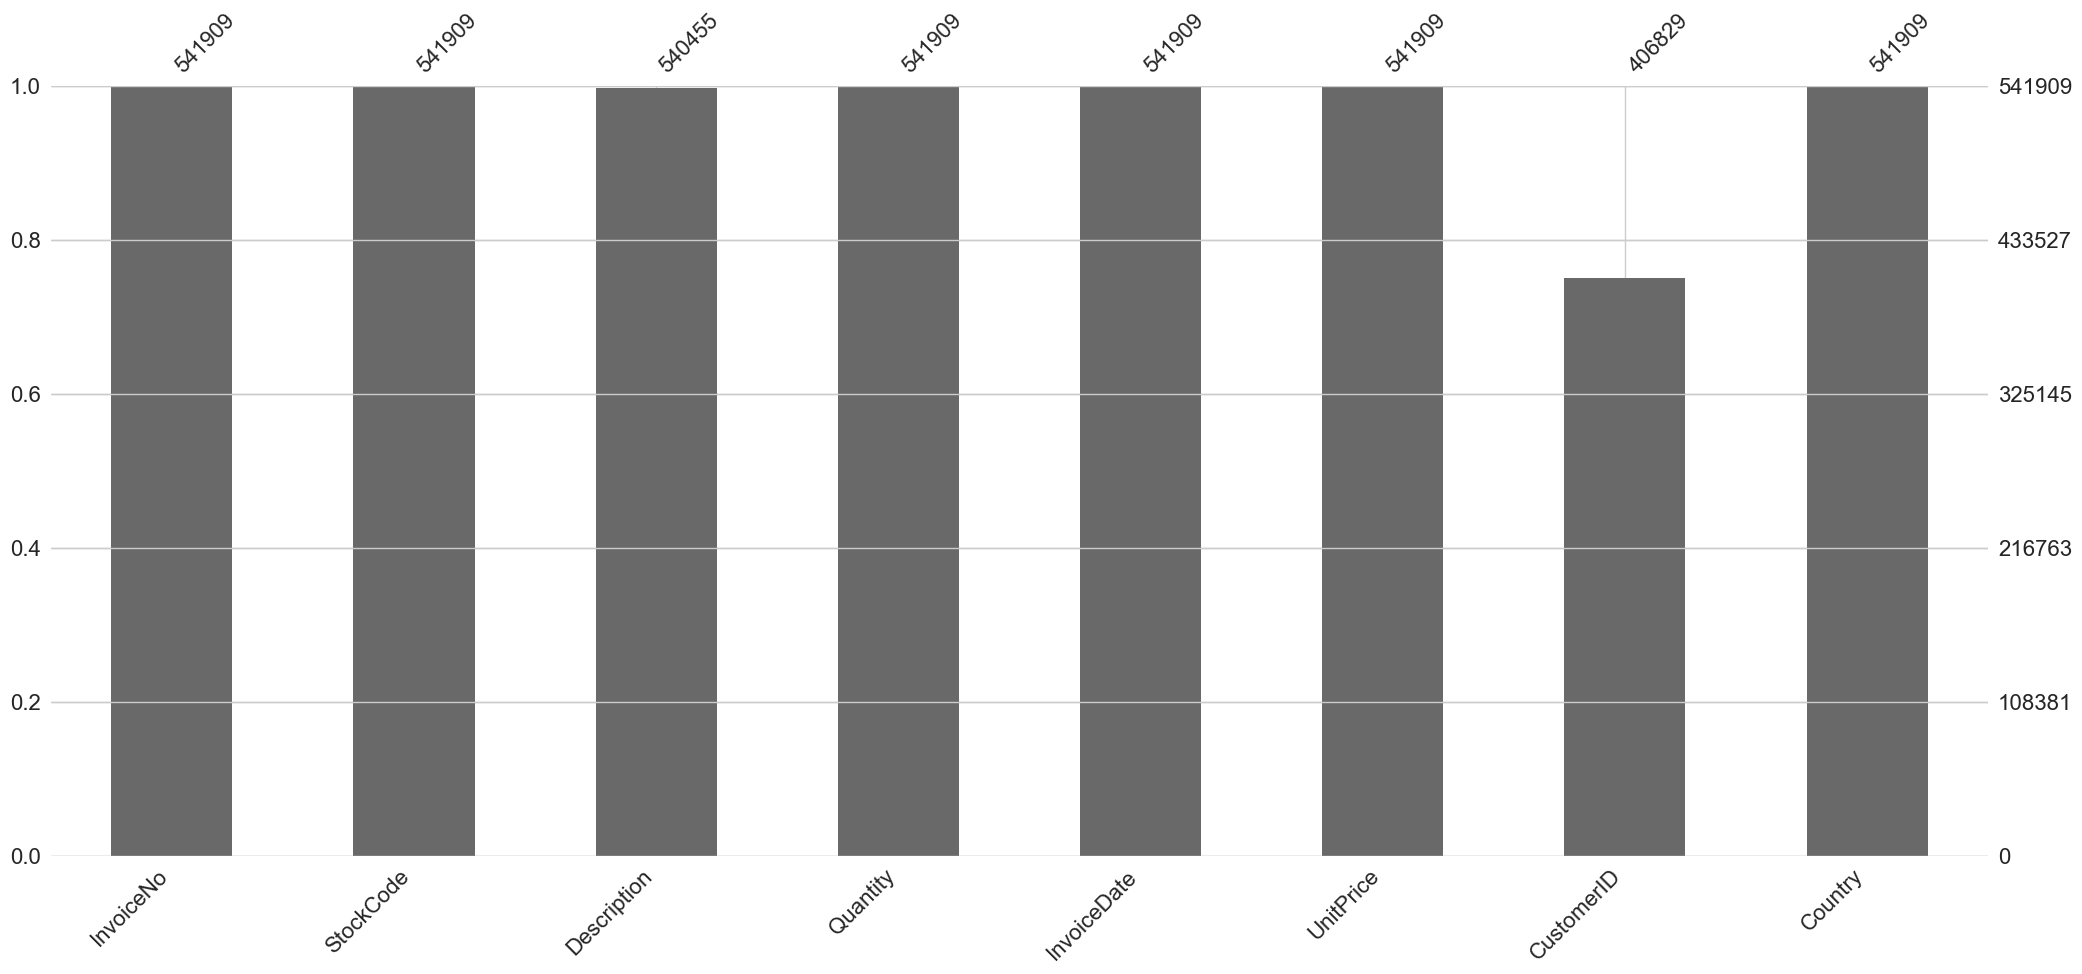

In [6]:
print ('Total number of obseration is:',df.shape[0])
msno.bar(df) # There are missing values in Description and CustomerID

In [7]:
# Finding the number of missing data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Delete the missing data 
df.dropna(inplace =True)

In [9]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# Drop the negative value
df.drop(df[df['Quantity'] < 0].index, inplace = True)
df.drop(df[df['UnitPrice'] < 0].index, inplace = True)

# Check if there are negative values
df[df['Quantity']<0].shape[0], df[df['UnitPrice']<0].shape[0] 


(0, 0)

In [11]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
# Calculating monetary value
df['TotalAmount']=df['UnitPrice']*df['Quantity']
ta=df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
ta

,CustomerID,TotalAmount
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4334,18280.0,180.60
4335,18281.0,80.82
4336,18282.0,178.05
4337,18283.0,2094.88


In [13]:
# Calculating frequency (Invoice no.)
freq=df.groupby('CustomerID')['InvoiceNo'].count().reset_index()
freq

,CustomerID,InvoiceNo
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4334,18280.0,10
4335,18281.0,7
4336,18282.0,12
4337,18283.0,756


In [14]:
# Calculating recency (last transaction)

df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Recency']=(df['InvoiceDate'].max()-df['InvoiceDate']).dt.days
lt=df.groupby(['CustomerID','Country'])['Recency'].max().reset_index()
lt

,CustomerID,Country,Recency
0,12346.0,United Kingdom,325
1,12347.0,Iceland,366
2,12348.0,Finland,357
3,12349.0,Italy,18
4,12350.0,Norway,309
...,...,...,...
4342,18280.0,United Kingdom,277
4343,18281.0,United Kingdom,180
4344,18282.0,United Kingdom,125
4345,18283.0,United Kingdom,336


In [15]:
# RFM dataset (Recency, Frequency and Monetary value)

merge1=pd.merge(lt,freq,how='inner',on='CustomerID')
new_df=pd.merge(merge1,ta,how='inner',on='CustomerID')
new_df.columns=['CustomerID','Country','Last_transaction','InvoiceNo','TotalAmount']
new_df

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,12346.0,United Kingdom,325,1,77183.60
1,12347.0,Iceland,366,182,4310.00
2,12348.0,Finland,357,31,1797.24
3,12349.0,Italy,18,73,1757.55
4,12350.0,Norway,309,17,334.40
...,...,...,...,...,...
4342,18280.0,United Kingdom,277,10,180.60
4343,18281.0,United Kingdom,180,7,80.82
4344,18282.0,United Kingdom,125,12,178.05
4345,18283.0,United Kingdom,336,756,2094.88


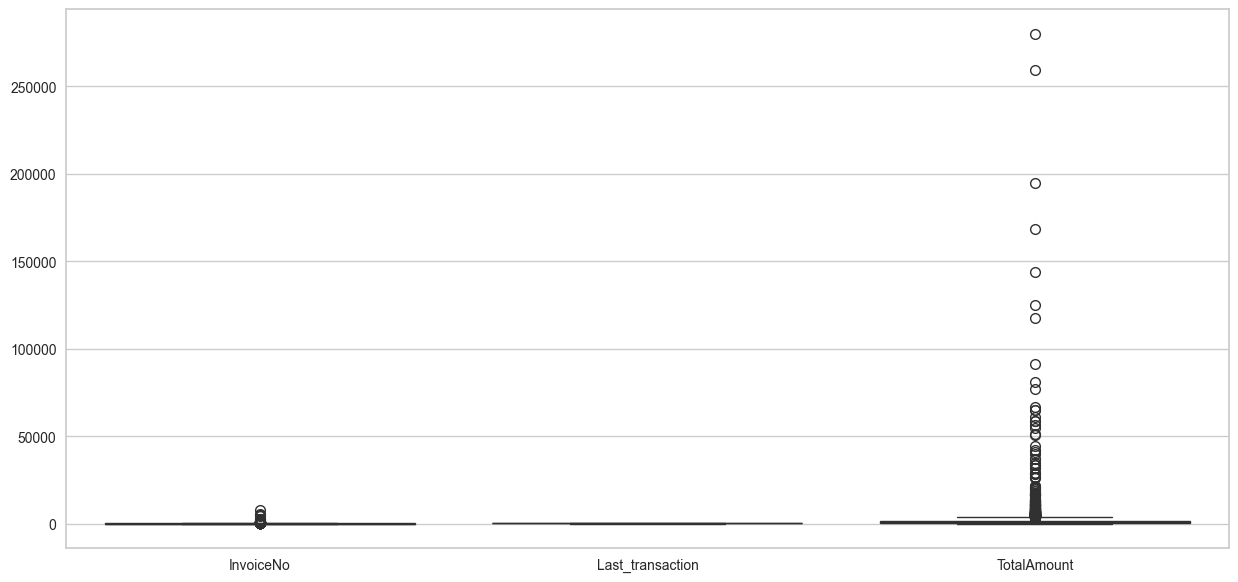

In [16]:
# Check to see if there are outliers

plt.figure(figsize=(15,7))
sns.boxplot(data = new_df[['InvoiceNo','Last_transaction','TotalAmount']])
plt.show() # There are many outliers in TotalAmount

In [17]:
# Remove the outliers

IQR=new_df['TotalAmount'].quantile(0.75) - new_df['TotalAmount'].quantile(0.25)

lower_limit=new_df['TotalAmount'].quantile(0.25) - 1.5*IQR
upper_limit=new_df['TotalAmount'].quantile(0.75) + 1.5*IQR

u=new_df[new_df['TotalAmount']>upper_limit]
l=new_df[new_df['TotalAmount']<lower_limit]

df_iqr = new_df[(new_df['TotalAmount']<upper_limit) & (new_df['TotalAmount']>lower_limit)]

print('Data before removing outliers: \n',new_df.shape)
print('\nData after removing outliers: \n',df_iqr.shape)
print('\nNumber of outliers: \n', len(u)+len(l))

Data before removing outliers: 
 (4347, 5)

Data after removing outliers: 
 (3923, 5)

Number of outliers: 
 424


Box plot before removing outliers: 



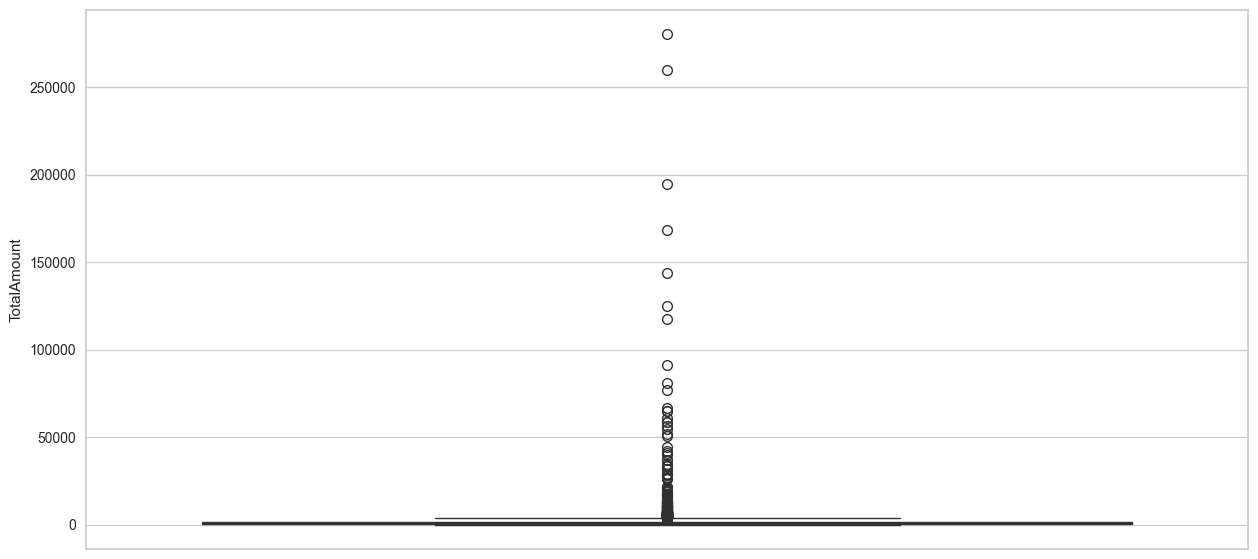


Box plot after removing outliers: 



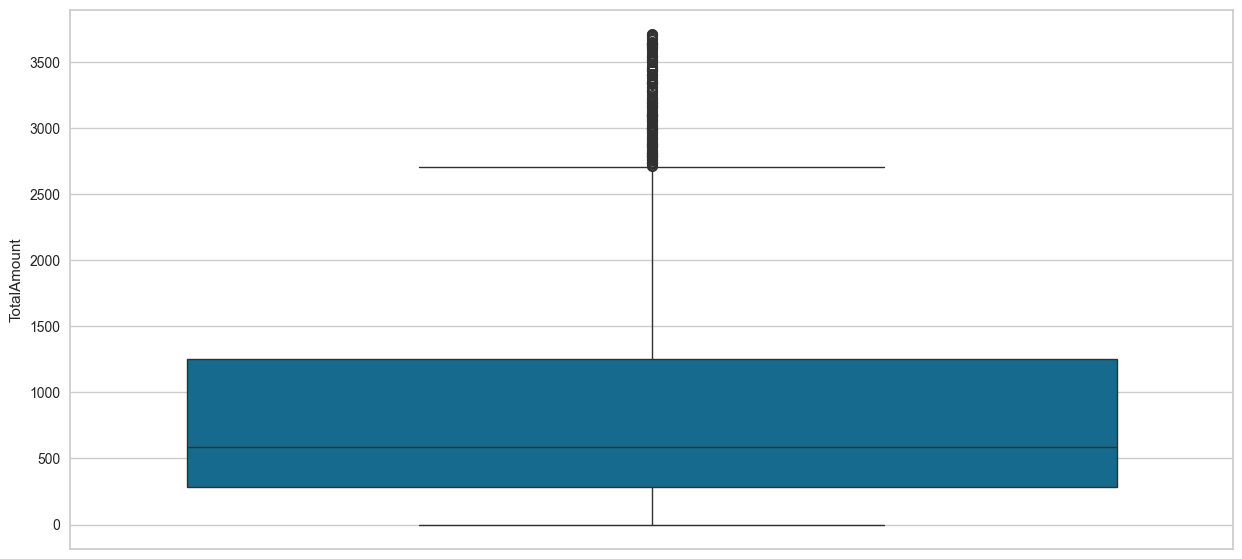

In [18]:
# Box plot before removing outliers
plt.figure(figsize=(15,7))
sns.boxplot(new_df['TotalAmount'])
print('Box plot before removing outliers: \n')
plt.show() 

# Box plot after removing outliers
plt.figure(figsize=(15,7))
sns.boxplot(df_iqr['TotalAmount'])
print('\nBox plot after removing outliers: \n')
plt.show() 

In [19]:
# New dataframe
df_iqr.reset_index(drop=True,inplace=True)
df_iqr

,CustomerID,Country,Last_transaction,InvoiceNo,TotalAmount
0,12348.0,Finland,357,31,1797.24
1,12349.0,Italy,18,73,1757.55
2,12350.0,Norway,309,17,334.40
3,12352.0,Norway,296,85,2506.04
4,12353.0,Bahrain,203,4,89.00
...,...,...,...,...,...
3918,18280.0,United Kingdom,277,10,180.60
3919,18281.0,United Kingdom,180,7,80.82
3920,18282.0,United Kingdom,125,12,178.05
3921,18283.0,United Kingdom,336,756,2094.88


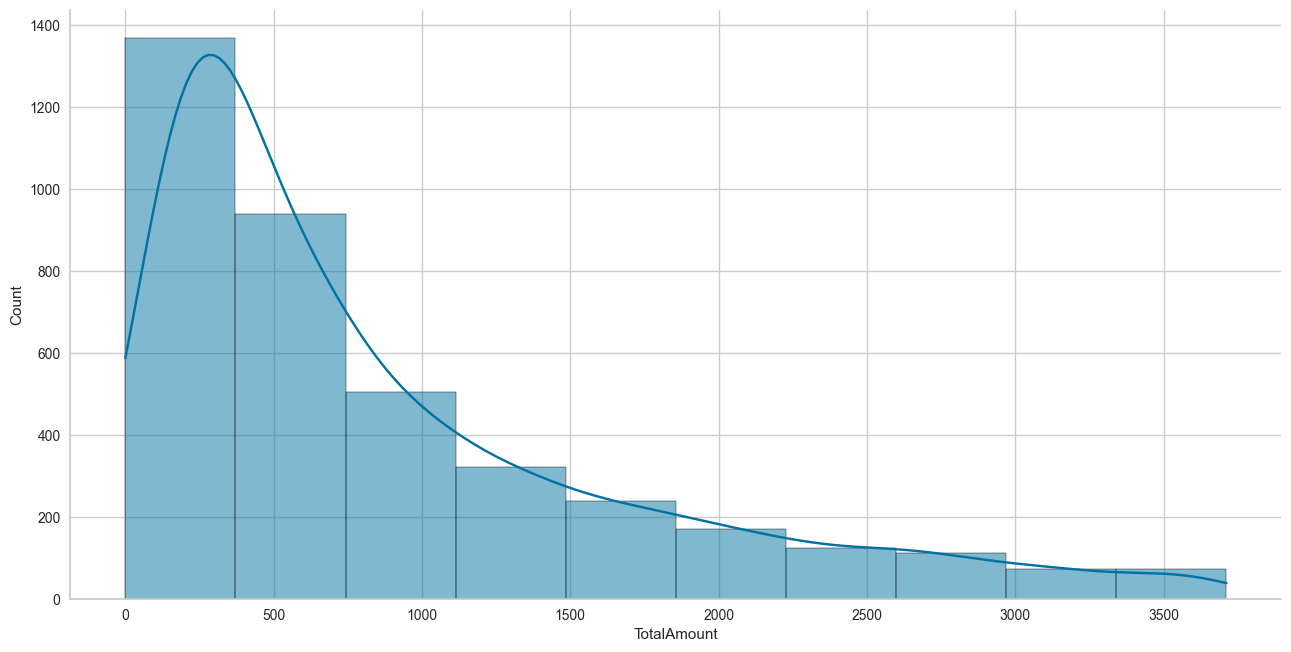

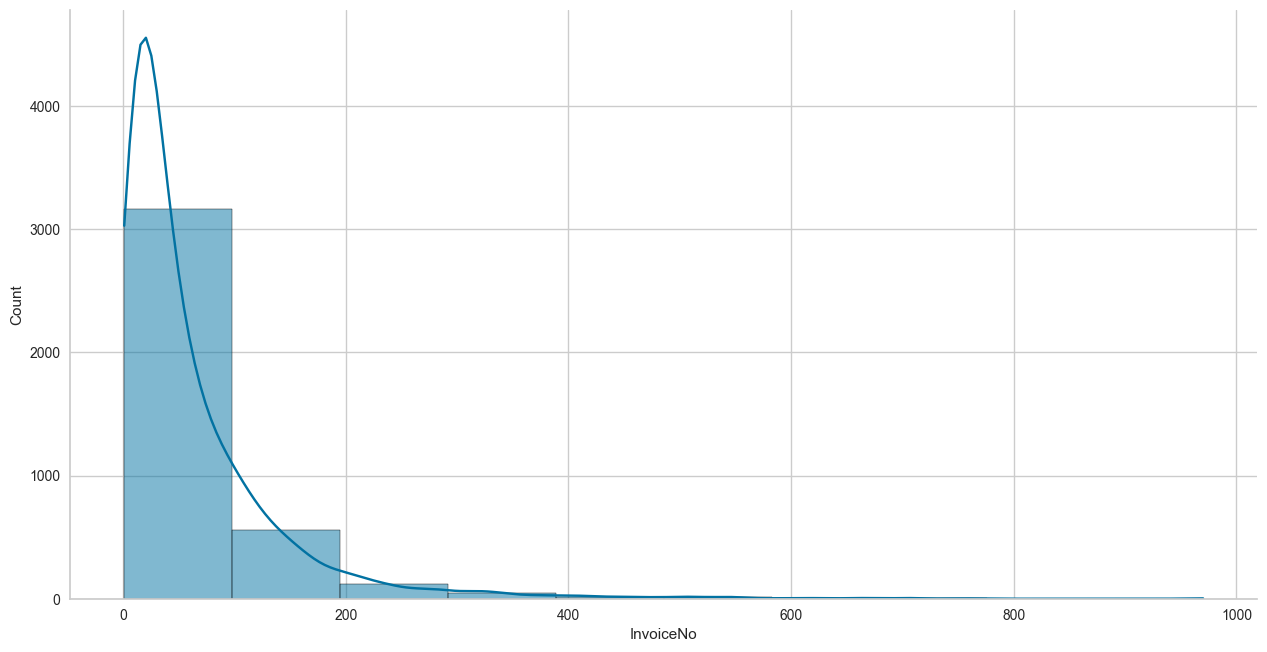

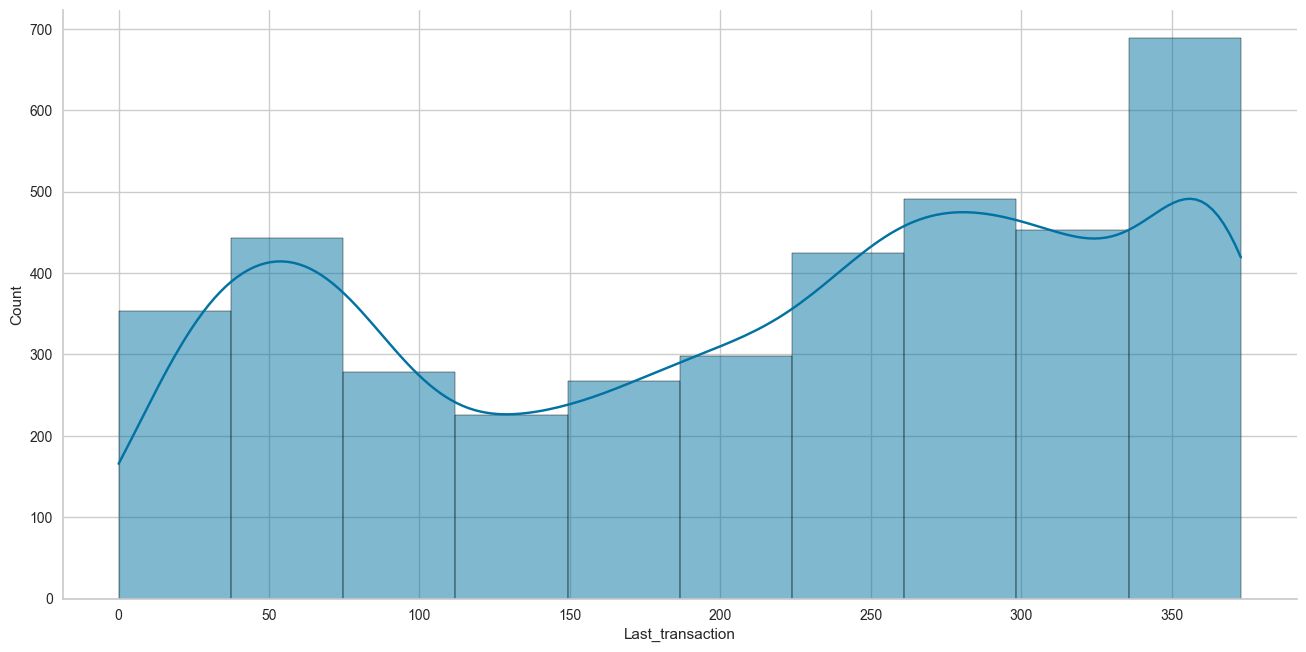

In [20]:
#Histogram Plot: 
new1_df=df_iqr.copy()
df_num=['TotalAmount','InvoiceNo','Last_transaction']
for i in df_num:
    sns.displot(new1_df[i],bins=10,kde=True)
    plt.gcf().set_size_inches(15, 7)
    plt.show()

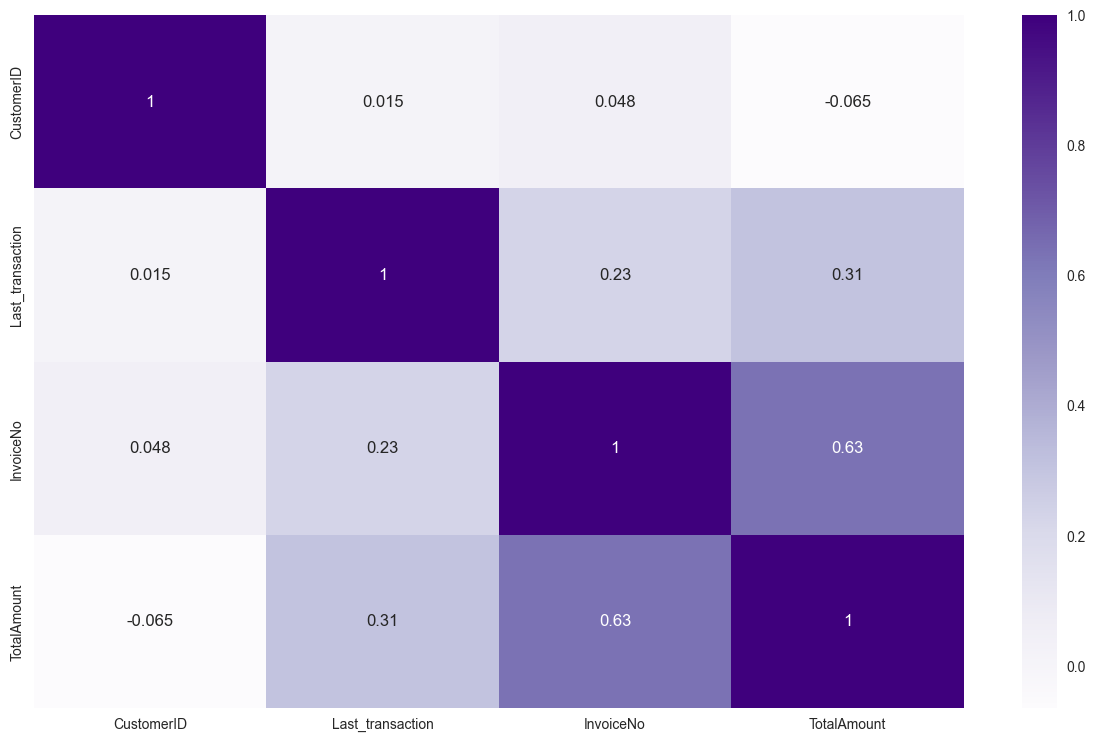

In [21]:
numeric_df = new1_df.select_dtypes(include='number')

# Heatmap
plt.figure(figsize=(15, 9))
sns.heatmap(numeric_df.corr(), cmap="Purples", annot=True)
plt.show()

In [22]:
#Each square shows the correlation between the variables on each axis.
#Values closer to zero means there is no linear trend between the two variables.
#The close to 1 the correlation is the more positively correlated they are;
#A correlation closer to -1 is similar, but instead of both increasing one variable will decrease as the other increases.
#As the heatmap shows, Total Amount and InvoiceNo is correlated positively

<Figure size 1500x800 with 0 Axes>

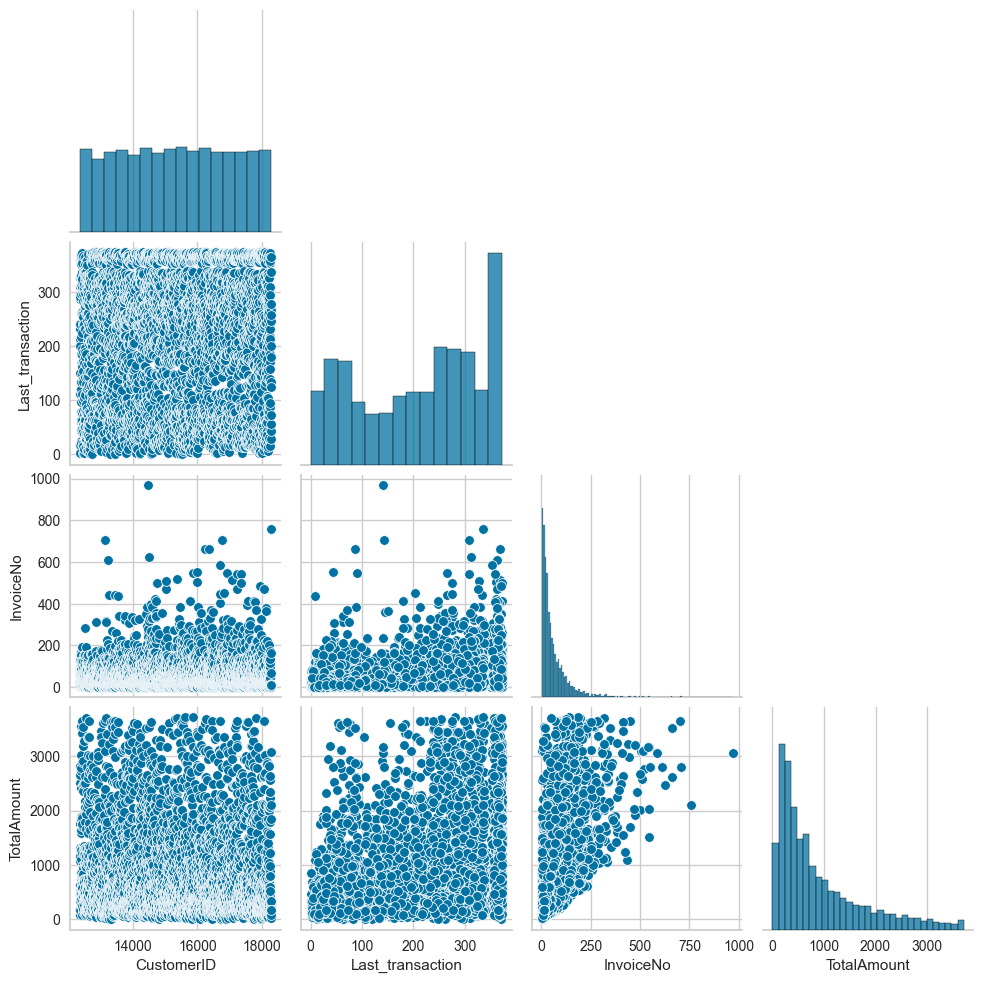

In [23]:
# Pairplot
plt.figure(figsize=(15,8))
sns.pairplot(new1_df, corner=True)
plt.show()

In [24]:
# Normalise the data
new2_df=new1_df[['Last_transaction','InvoiceNo','TotalAmount']]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(new2_df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns=['Last_transaction','InvoiceNo','TotalAmount']
scaled_df['Country']=new1_df['Country']
scaled_df

,Last_transaction,InvoiceNo,TotalAmount,Country
0,0.957105,0.030960,0.484200,Finland
1,0.048257,0.074303,0.473507,Italy
2,0.828418,0.016512,0.090092,Norway
3,0.793566,0.086687,0.675160,Norway
4,0.544236,0.003096,0.023978,Bahrain
...,...,...,...,...
3918,0.742627,0.009288,0.048656,United Kingdom
3919,0.482574,0.006192,0.021774,United Kingdom
3920,0.335121,0.011352,0.047969,United Kingdom
3921,0.900804,0.779154,0.564388,United Kingdom


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_k

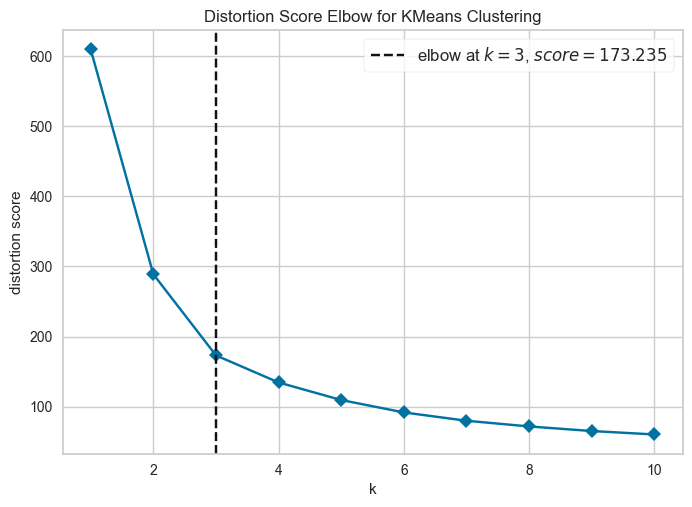

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(df_k)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [26]:
df_k=scaled_df.drop(columns=['Country'],axis=1)
df_k

,Last_transaction,InvoiceNo,TotalAmount
0,0.957105,0.030960,0.484200
1,0.048257,0.074303,0.473507
2,0.828418,0.016512,0.090092
3,0.793566,0.086687,0.675160
4,0.544236,0.003096,0.023978
...,...,...,...
3918,0.742627,0.009288,0.048656
3919,0.482574,0.006192,0.021774
3920,0.335121,0.011352,0.047969
3921,0.900804,0.779154,0.564388


C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_k

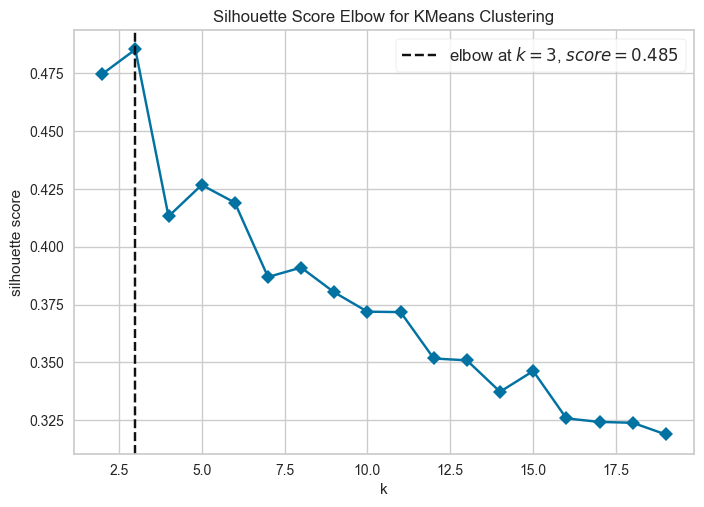

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [27]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= False)
visualizer.fit(df_k)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [28]:
# Add the number of cluster columns in the data frame
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_k)
df_k['clusters']= y_predicted
df_k

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Last_transaction,InvoiceNo,TotalAmount,clusters
0,0.957105,0.030960,0.484200,0
1,0.048257,0.074303,0.473507,1
2,0.828418,0.016512,0.090092,2
3,0.793566,0.086687,0.675160,0
4,0.544236,0.003096,0.023978,2
...,...,...,...,...
3918,0.742627,0.009288,0.048656,2
3919,0.482574,0.006192,0.021774,1
3920,0.335121,0.011352,0.047969,1
3921,0.900804,0.779154,0.564388,0


In [29]:
# Cluster centroid:
km.cluster_centers_

array([[0.79772814, 0.15815237, 0.63292161],
       [0.22058455, 0.04002649, 0.14850462],
       [0.77657312, 0.04268071, 0.15735133]])

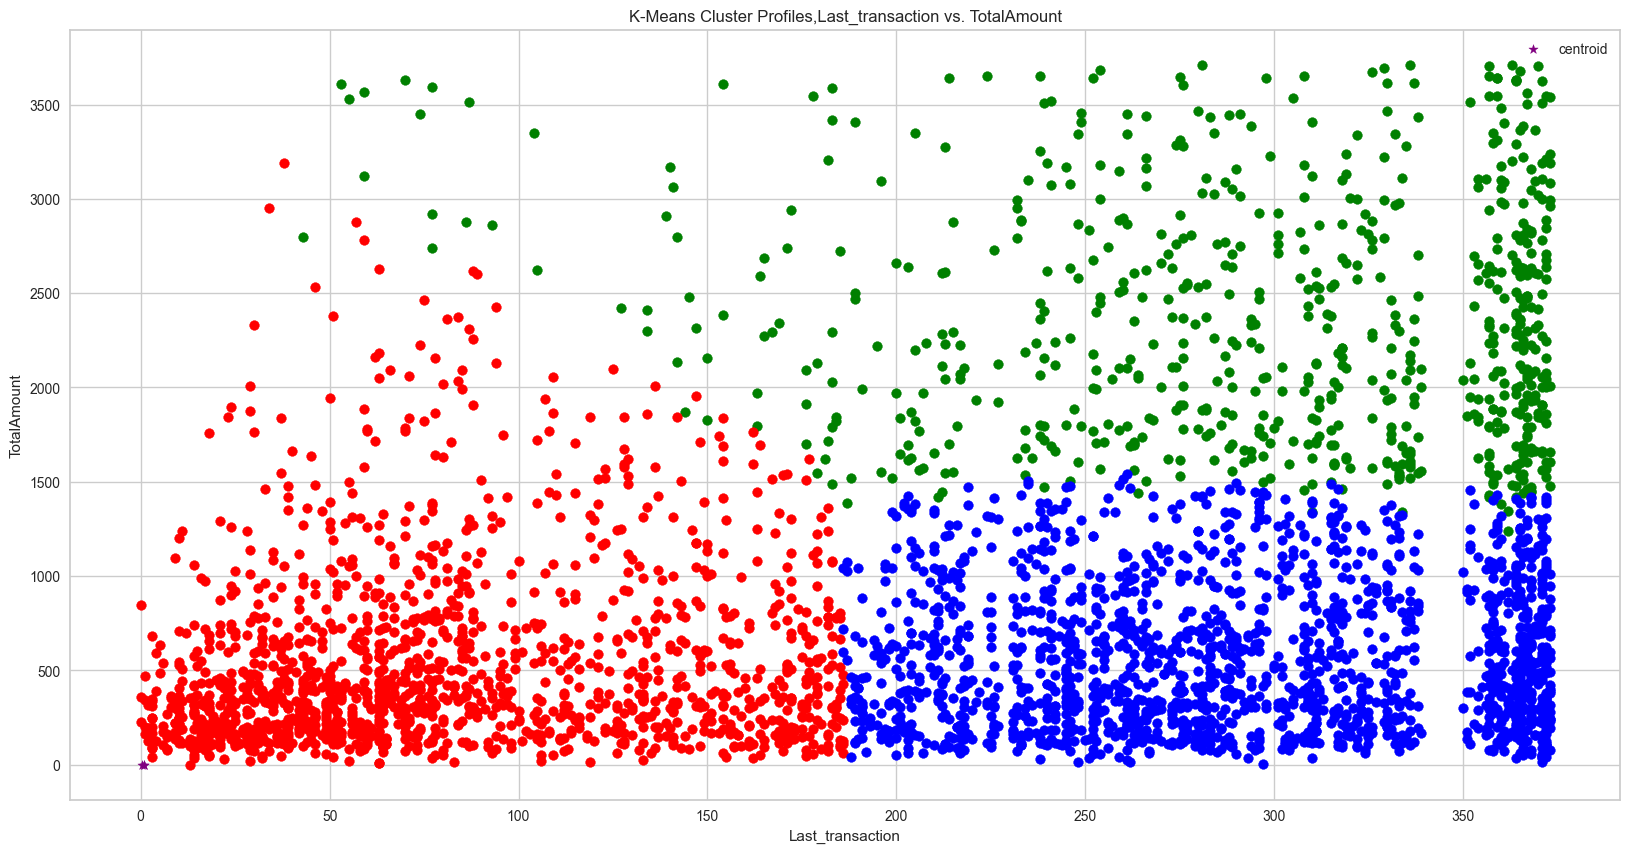

In [30]:
# Visualize the clusters with original data
new2_df['clusters']= y_predicted
df1 = new2_df[new2_df.clusters==0]
df2 = new2_df[new2_df.clusters==1]
df3 = new2_df[new2_df.clusters==2]
plt.figure(figsize=(20,10))
plt.scatter(df1.Last_transaction,df1['TotalAmount'],color='green')
plt.scatter(df2.Last_transaction,df2['TotalAmount'],color='red')
plt.scatter(df3.Last_transaction,df3['TotalAmount'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.legend()
plt.xlabel('Last_transaction')
plt.ylabel('TotalAmount')
plt.title('K-Means Cluster Profiles,Last_transaction vs. TotalAmount')
plt.show()

In [31]:
#Cluster 0 consists of customers with the last_transaction between 0 and 180 days, and total amount spent between 0 to $2500;
#Cluster 1 consist of customers with the last_transaction between 180 and 400 days, and total amount spent between 0 and $1500;
#Cluster 2 consits of custoemrs with the last_transaction between 50 and 400 days, and total amount spent between 1500 and 3500;